<a href="https://colab.research.google.com/github/lukeeees/ADMN5015/blob/main/text2speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing - Speech-to-text
Author: Luke Nigel Laylo


---



* Enable your Google Cloud Platform (GCP) Speech-to-Text API.
* Enable your GCP Natural Language API.
* Create or reuse a GCP Service Account.
* Create a call center audio file (WAV extensions work best).
* Create a bucket in GCP Storage.
* Upload your audio WAV file to your GCP Storage bucket (your audio file must be different from the one used in class).
* Extract the text from your audio file.
* Run a sentiment analysis process on the extracted audio text.
* Store each speech-extracted record in a No-SQL database like Firestore.  Your database must have these keys in each document:
** wav_filename (e.g. "1.wav")
** sentence_number (e.g. 1) 
** sentence_text (e.g. "Thanks for calling XYZ my name is John")
** sentiment (e.g. 0.87)
** magnitude (e.g. 1.2)
** transcription_date (e.g. "2023-01-28")
*Visualize your findings.

In [1]:
#!pip install --upgrade google-cloud-storage --quiet

In [2]:
#!pip install --upgrade google-cloud-speech --quiet


In [32]:
#imports
import os
from google.cloud import storage
from google.cloud import speech
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from google.cloud import language_v1
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Create environment variable for google services

In [4]:
# Create environment variable for google cloud storage
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content'+os.sep+'admn-5015-3282eb056f4f.json'
BUCKET_NAME  = 'my-new-bucket-luke-laylo-14344'
cred = credentials.Certificate('/content'+os.sep+'admn-5015-3282eb056f4f.json')
app = firebase_admin.initialize_app(cred)


In [5]:
# # Imports the Google Cloud client library
# from google.cloud import storage

# # Instantiates a client
# storage_client = storage.Client()

# # The name for the new bucket
# bucket_name = "my-new-bucket-luke-laylo-14344"

# # Creates the new bucket
# bucket = storage_client.create_bucket(bucket_name)

# print(f"Bucket {bucket.name} created.")

## Extract Audio and save to Firebase

In [10]:
def list_blobs(bucket_name):
    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    return blobs


def extract_audio_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""

    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        audio_channel_count=2,
        language_code="en-US",
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=600)

    return response

def sentiment_analyzer(transcript):
    """
    Analyzes the sentiment of the text.
    """
    client = language_v1.LanguageServiceClient()

    # The text to analyze
    text = transcript
    document = language_v1.Document(
    content=text, type_=language_v1.Document.Type.PLAIN_TEXT
    )

    # Detects the sentiment of the text
    sentiment = client.analyze_sentiment(
    request={"document": document}
    ).document_sentiment

    return sentiment
    

def save_to_db(number,transcript,sentiment,magnitude):
    # TODO: save to db

    db = firestore.client()    
    doc_ref = db.collection(u'Callcenter').document()
    doc_ref.set({
        u'wav_filename': u'callcenter.wav',
        u'sentence_number': number,
        u'sentence_text': transcript,
        u'sentiment': sentiment,
        u'magnitude': magnitude,
        u'transcription_date': firestore.SERVER_TIMESTAMP
    })
    print('Document {} created'.format(doc_ref.id))

In [11]:
def main():

    blobs = list_blobs(BUCKET_NAME)
    # Extract audio from each file
    for blob in blobs:

        gcs_uri = "gs://" + BUCKET_NAME + "/" + blob.name
        print("\nThis is the uri: {}".format(gcs_uri))

        response = extract_audio_gcs(gcs_uri)
        count = 0
        for result in response.results:
            alternative = result.alternatives[0]
            print(u"Transcript: {}".format(alternative.transcript))    
            print(u"Confidence: {}".format(alternative.confidence))
            sentiment = sentiment_analyzer(alternative.transcript)
            print(sentiment.score)
            print(sentiment.magnitude)
            save_to_db(count,alternative.transcript, sentiment.score, sentiment.magnitude)
            count +=1


  
if __name__ == "__main__":
  main()


This is the uri: gs://my-new-bucket-luke-laylo-14344/callcenter.wav
Waiting for operation to complete...
Transcript: thank you for calling Master booze this is a Saleen how can I help you today
Confidence: 0.8807554841041565
0.20000000298023224
0.20000000298023224
Document e9LqiK1htP35V80lyhVZ created
Transcript:  you tell me I'm looking at my statement that it's either you guys charge my credit card for $67.81 when it initially signed up for a $40 plan guess what my bank charged me for an overdraft fee this is ridiculous if I know that you lied to me I should have chosen global phone instead very very disappointing I've been with you guys for so many years now I've started my account in postpaid I decided to switch over prepay and I want you to cancel my account completely with this again
Confidence: 0.965475857257843
-0.800000011920929
0.800000011920929
Document arNzDTBcEll1vmq9Zsbz created
Transcript:  Egyptian amount of money and I want to make sure that this will be taken care of

## Fetching data from Firebase

In [35]:
db = firestore.client() 

# # Read data from Firestore
users_ref = db.collection(u'Callcenter')
docs = users_ref.stream()

number= []
transcript= []
sentiment_score= []
sentiment_magnitude= []
timestamp = []
for doc in docs:
    number.append(doc.to_dict().get('sentence_number'))
    transcript.append(doc.to_dict().get('sentence_text'))
    sentiment_score.append(doc.to_dict().get('sentiment'))
    sentiment_magnitude.append(doc.to_dict().get('magnitude'))
    timestamp.append(doc.to_dict().get('transcription_date'))

df = pd.DataFrame({'sentence_number':number, 'sentence_text':transcript, 'sentiment':sentiment_score, 'sentiment_magnitude':sentiment_magnitude, 'timestamp':timestamp})

In [36]:
df.head()

,sentence_number,sentence_text,sentiment,sentiment_magnitude,timestamp
0,14,all right now is she feed betta Checker payme...,-0.8,0.8,2023-02-03 03:29:44.582000+00:00
1,2,Egyptian amount of money and I want to make s...,-0.3,0.3,2023-02-03 03:29:40.918000+00:00
2,8,well that's quite a lot to do you think that ...,-0.5,0.5,2023-02-03 03:29:42.782000+00:00
3,19,you're welcome Linda I appreciate your board ...,0.8,0.8,2023-02-03 03:29:46.058000+00:00
4,3,my name is Linda Marrone and you better do so...,-0.1,0.1,2023-02-03 03:29:41.210000+00:00


In [29]:
df.shape

(22, 5)

In [14]:
# save to csv
df.to_csv('sentiment_data.csv', index=False)

## Findings

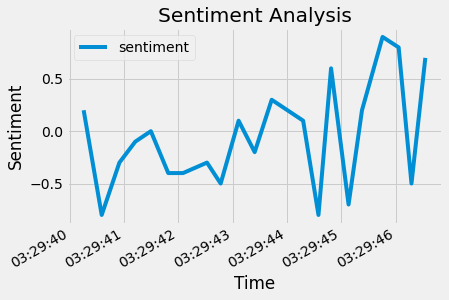

In [25]:
# visualize data by line graph

df.plot(x='timestamp', y='sentiment', kind ='line')
plt.title('Sentiment Analysis')
plt.xlabel('Time')
plt.ylabel('Sentiment')
plt.show()

### Obeservations
We can see that the conversation started with the agent with a please introduction but the customer was not happy with the service at first. The client tried to be patient even if the customer was always negative.

We can see that the conversation towards the end the conversation is positive.

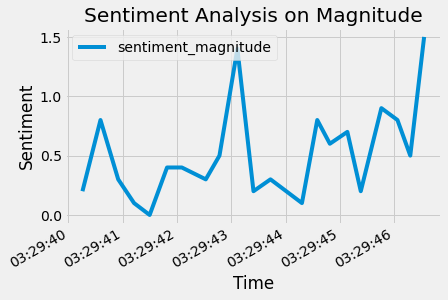

In [28]:
# visualize data by line graph

df.plot(x='timestamp', y='sentiment_magnitude', kind ='line')
plt.title('Sentiment Analysis on Magnitude')
plt.xlabel('Time')
plt.ylabel('Sentiment')
plt.show()

### Observations
This graph shows how intense the conversation between the customer and the agent went where it didn't escalate to a very bad conversation. 

We could see that the conversation was between neutral - positive.

We can say that the agent was able to empathize with the customer and resolved the problems the customer encountered.